In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [4]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])

In [5]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [6]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [7]:
statmad_dic = {
    'Run Time': [],
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []
}

indaccs = {}

In [8]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 16].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 16].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statmad_dic['Run Time'].append(elapsed)
statmad_dic['Accuracy'].append(np.mean(acc_score))
statmad_dic['Standard Error'].append(np.std(acc_score))
statmad_dic['Sensitivity'].append(sensitivity)
statmad_dic['Specificity'].append(specificity)
statmad_dic['Precision'].append(precision)
statmad_dic['F1_Score'].append(f1_score)

indaccs['LogReg'] = acc_score

---Run time is 0.26683000699999937 seconds ---

Accuracy of each fold: 
 [0.7701432753042674, 0.7597842835130971, 0.7636363636363637, 0.7690292758089369, 0.7642526964560863]
Avg accuracy: 0.7653691789437502
Std of accuracy : 
0.0037849318125471117

[[18048  1378]
 [ 6236  6789]]

              precision    recall  f1-score   support

           0       0.74      0.93      0.83     19426
           1       0.83      0.52      0.64     13025

    accuracy                           0.77     32451
   macro avg       0.79      0.73      0.73     32451
weighted avg       0.78      0.77      0.75     32451

0.9290641408421703
0.5212284069097889
0.7432054027343107
0.8258064516129032


In [9]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 16].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 16].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statmad_dic['Run Time'].append(elapsed)
statmad_dic['Accuracy'].append(np.mean(acc_score))
statmad_dic['Standard Error'].append(np.std(acc_score))
statmad_dic['Sensitivity'].append(sensitivity)
statmad_dic['Specificity'].append(specificity)
statmad_dic['Precision'].append(precision)
statmad_dic['F1_Score'].append(f1_score)

indaccs['LDA'] = acc_score

---Run time is 0.21346334000000056 seconds ---

Accuracy of each fold: 
 [0.7342474195039285, 0.7286594761171032, 0.7385208012326656, 0.7432973805855162, 0.7306625577812018]
Avg accuracy: 0.735077527044083
Std of accuracy : 
0.00530649675778821

[[18359  1067]
 [ 7530  5495]]

              precision    recall  f1-score   support

           0       0.71      0.95      0.81     19426
           1       0.84      0.42      0.56     13025

    accuracy                           0.74     32451
   macro avg       0.77      0.68      0.69     32451
weighted avg       0.76      0.74      0.71     32451

0.9450736126840317
0.4218809980806142
0.7091428792151107
0.8102835705616241


In [10]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    
    X_train = subject_df.iloc[train_index, 16].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 16].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statmad_dic['Run Time'].append(elapsed)
statmad_dic['Accuracy'].append(np.mean(acc_score))
statmad_dic['Standard Error'].append(np.std(acc_score))
statmad_dic['Sensitivity'].append(sensitivity)
statmad_dic['Specificity'].append(specificity)
statmad_dic['Precision'].append(precision)
statmad_dic['F1_Score'].append(f1_score)

indaccs['QDA'] = acc_score

---Run time is 0.08419274199999904 seconds ---

Accuracy of each fold: 
 [0.7186874133415498, 0.7161787365177196, 0.7248073959938367, 0.7331278890600924, 0.7157164869029276]
Avg accuracy: 0.7217035843632251
Std of accuracy : 
0.00656680975500686

[[18454   972]
 [ 8059  4966]]

              precision    recall  f1-score   support

           0       0.70      0.95      0.80     19426
           1       0.84      0.38      0.52     13025

    accuracy                           0.72     32451
   macro avg       0.77      0.67      0.66     32451
weighted avg       0.75      0.72      0.69     32451

0.9499639658190054
0.3812667946257198
0.6960359069135895
0.8034132218811904


In [11]:
#KNN-CV
KNN_result = []
X=subject_df["MAD"].values.reshape(-1,1)
Y=subject_df["Mappedrhythmlabels"]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,31):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K = {}'.format(k))
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(np.max(KNN_result))

K = 1
Accuracy of each fold: 
 [0.77507318 0.72634823 0.74268105 0.74067797 0.69399076]
Avg accuracy: 0.7357542350330278

K = 2
Accuracy of each fold: 
 [0.74410723 0.73929122 0.73882897 0.73898305 0.703698  ]
Avg accuracy: 0.732981691610928

K = 3
Accuracy of each fold: 
 [0.77800031 0.77411402 0.74807396 0.74422188 0.73050847]
Avg accuracy: 0.7549837288040641

K = 4
Accuracy of each fold: 
 [0.76228624 0.75978428 0.75639445 0.74437596 0.70862866]
Avg accuracy: 0.7462939203006937

K = 5
Accuracy of each fold: 
 [0.77707595 0.76502311 0.75038521 0.75654854 0.71294299]
Avg accuracy: 0.7523951594468008

K = 6
Accuracy of each fold: 
 [0.78662764 0.75716487 0.78212635 0.75993837 0.74884438]
Avg accuracy: 0.7669403196413477

K = 7
Accuracy of each fold: 
 [0.79802804 0.74714946 0.78382126 0.7624037  0.73836672]
Avg accuracy: 0.7659538358077405

K = 8
Accuracy of each fold: 
 [0.79279002 0.74252696 0.78921418 0.78998459 0.78043143]
Avg accuracy: 0.778989436363114

K = 9
Accuracy of each fol

In [12]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=7)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    
    X_train = subject_df.iloc[train_index, 16].values.reshape(-1,1)
    X_test = subject_df.iloc[test_index, 16].values.reshape(-1,1)
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statmad_dic['Run Time'].append(elapsed)
statmad_dic['Accuracy'].append(np.mean(acc_score))
statmad_dic['Standard Error'].append(np.std(acc_score))
statmad_dic['Sensitivity'].append(sensitivity)
statmad_dic['Specificity'].append(specificity)
statmad_dic['Precision'].append(precision)
statmad_dic['F1_Score'].append(f1_score)

indaccs['KNN-CV'] = acc_score


---Run time is 4.3056749189999834 seconds ---

Accuracy of each fold: 
 [0.7980280388229857, 0.7471494607087827, 0.7838212634822804, 0.7624036979969183, 0.738366718027735]
Avg accuracy: 0.7659538358077405
Std of accuracy : 
0.02224974849077672

[[15222  4204]
 [ 3391  9634]]

              precision    recall  f1-score   support

           0       0.82      0.78      0.80     19426
           1       0.70      0.74      0.72     13025

    accuracy                           0.77     32451
   macro avg       0.76      0.76      0.76     32451
weighted avg       0.77      0.77      0.77     32451

0.7835890044270565
0.7396545105566219
0.8178155052920002
0.800336496753332


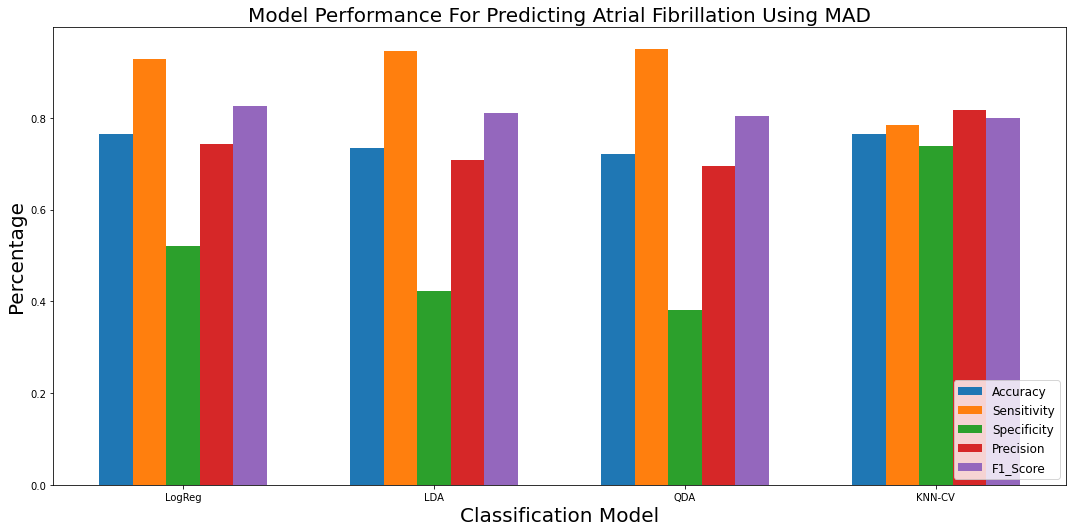

In [13]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statmad_dic["Accuracy"]
sensitivities = statmad_dic["Sensitivity"]
specificities = statmad_dic["Specificity"]
precisions = statmad_dic["Precision"]
f1_scores = statmad_dic["F1_Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(15, 7.5))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy')
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity')
spe = ax.bar(x,specificities, width, label='Specificity')
pre = ax.bar(x+width, precisions, width, label='Precision')
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score')

ax.set_xlabel('Classification Model', fontsize=20)
ax.set_ylabel('Percentage', fontsize=20)
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using MAD', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.legend(loc="lower right", prop={'size': 12})
plt.show()

fig.savefig('MadModel.png')

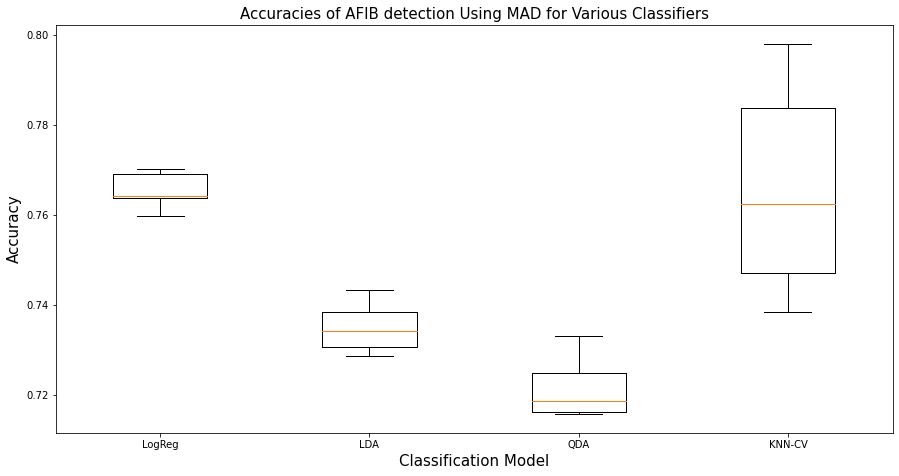

In [14]:
#Box Plots

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs['LogReg']
LDAAcc = indaccs['LDA']
QDAAcc = indaccs['QDA']
KNNAcc = indaccs['KNN-CV']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.boxplot(data)

ax.set_title('Accuracies of AFIB detection Using MAD for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

plt.show()

fig.savefig('MadBox.png')

In [15]:
iqrdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statmad_dic["Accuracy"],
                                statmad_dic["Standard Error"],
                                statmad_dic["Sensitivity"],
                                statmad_dic["Specificity"],
                                statmad_dic["Precision"],
                                statmad_dic["F1_Score"],
                                statmad_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

iqrdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.765369,0.003785,0.929064,0.521228,0.743205,0.825806,0.266830
LDA,0.735078,0.005306,0.945074,0.421881,0.709143,0.810284,0.213463
QDA,0.721704,0.006567,0.949964,0.381267,0.696036,0.803413,0.084193
KNN-CV,0.765954,0.022250,0.783589,0.739655,0.817816,0.800336,4.305675
